# From buttom:

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

""" This is code for simple GP regression. It assumes a zero mean GP Prior """


' This is code for simple GP regression. It assumes a zero mean GP Prior '

In [2]:

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


**The Gaussian kernel (or Radial Basis Function (RBF))**

$$ K_{SE}(x,x') = \sigma^2 exp(-0.5\frac{(x-x')^2}{2l²}) $$

- (why do you "-" with 0,5?)

- The lengthscale $l$ determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than $l$ units away from your data.

- The output variance $\sigma^2$ determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.

In [3]:

# Define the kernel
def kernelRBF(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 1#0.1#10
    outputVar = 1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return outputVar * np.exp(-.5 * (1/kernelParameter) * sqdist)


**Rational Quadratic Kernel**

$$ K_{RQ}(x,x') = \sigma^2 (1+\frac{(x-x')^2}{2\alpha l^2})^{-\alpha} $$

This kernel is equivalent to adding together many SE kernels with different lengthscales. So, GP priors with this kernel expect to see functions which vary smoothly across many lengthscales. The parameter α determines the relative weighting of large-scale and small-scale variations. When α→∞, the RQ is identical to the SE. 

In [4]:
# Define the kernel
def kernelRQ(a, b):
    """ GP squared exponential kernel """
    alpha = 1
    kernelParameter = 1#0.1#10
    outputVar = 2
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return outputVar * (1 + (1/(alpha*kernelParameter)) * sqdist)**(-alpha)


**Pitfalls of the SE and RQ kernels**

Most people who set up a GP regression or classification model end up using the Squared-Exp or Rational Quadratic kernels. They are a quick-and-dirty solution that will probably work pretty well for interpolating smooth functions when N is a multiple of D, and when there are no 'kinks' in your function. If your function happens to have a discontinuity or is discontinuous in its first few derivatives (for example, the abs() function), then either your lengthscale will end up being extremely short, and your posterior mean will become zero almost everywhere, or your posterior mean will have 'ringing' effects. Even if there are no hard discontinuities, the lengthscale will usually end up being determined by the smallest 'wiggle' in your function - so you might end up failing to extrapolate in smooth regions if there is even a small non-smooth region in your data.

If your data is more than two-dimensional, it may be hard to detect this problem. One indication is if the lengthscale chosen by maximum marginal likelihood never stops becoming smaller as you add more data. This is a classic sign of model misspecification. 

**Periodic Kernel**

$$K_{Per}(x,x') = \sigma^2 exp(-\frac{2sin^2(\pi|x-x'|/p)}{l^2})$$

The periodic kernel (derived by David Mackay) allows one to model functions which repeat themselves exactly. Its parameters are easily interpretable:

- The period p simply determines the distnace between repititions of the function.

- The lengthscale $l$ determines the lengthscale function in the same way as in the SE kernel.


se http://www.cs.toronto.edu/~duvenaud/cookbook/index.html for more

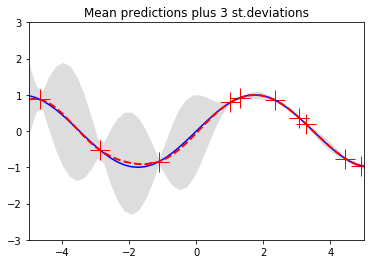

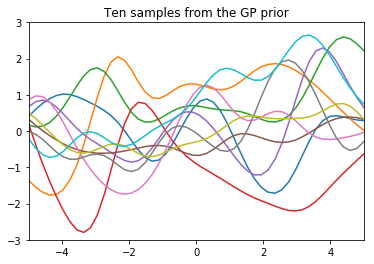

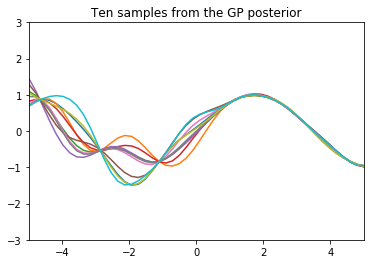

In [5]:
kernel = kernelRBF
#kernel = kernelRQ


N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points (grid, not testset!) we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
K_s =  kernel(X, Xtest) # K*
Lk = np.linalg.solve(L,K_s) 
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ss = kernel(Xtest, Xtest) # K**
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)


# PLOTS:-----------------------------------------------------------------------------------------------
plt.figure(1)
plt.clf()
plt.plot(X, y, 'r+', ms=20)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.savefig('predictive.png', bbox_inches='tight')
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))

plt.figure(2)
plt.clf()
plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior')
plt.axis([-5, 5, -3, 3])
plt.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))

plt.figure(3)
plt.clf()
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.savefig('post.png', bbox_inches='tight')

plt.show()

# Sklearn

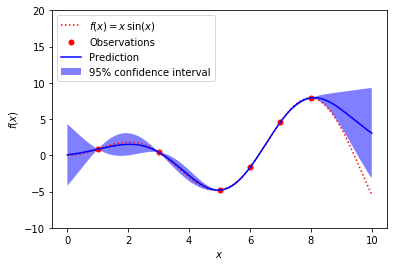

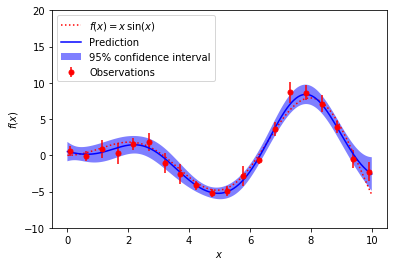

In [6]:


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()
#y = np.array([1.,2.,3.,1.,2.,4])


# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()